# Rules-based hit detection baseline only with shuttlecock info

Input: GT shuttle trajectory. Can also use TrackNetv2 as comparison (for am-singles, doubles)

Output: Frame indices with hits detected.

Method:
1. x,y maxima or minima. Or second derivative exceeds threshold.
2. Need smoothing first?

In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import shutil
import scipy.interpolate

In [2]:
gt_shuttle_rootdir = '../datasets/' # '../datasets/pro/match1/ball_trajectory/1_01_00_ball.csv'
annot_shuttle_rootdir = '../data_annotations/object_level/shuttle/' # (not available for pro) 'object_level/shuttle/am_singles/match_china2/singles0_shuttle.csv'
label_rootdir = '../datasets/' # '../datasets/pro/match1/player_hit/1_01_00.mp4_player_hit.csv'

## Visualisation

Plot shuttlecock x-y coordinates and correspondence with hits.

In [3]:
def vis_shuttle_hit_correspondence(shuttle_file, label_file):
    df_shuttle = pd.read_csv(shuttle_file)
    df_label = pd.read_csv(label_file)

    shuttle_coords = df_shuttle[['X', 'Y']].to_numpy()
    hit_labels = df_label['player_hit'].values
    frame_ind = df_label['frame'].values
    
    if len(shuttle_coords) < len(frame_ind):
        diff = len(frame_ind) - len(shuttle_coords)
        zeros = np.zeros((diff, 2))
        shuttle_coords = np.concatenate((shuttle_coords, zeros))
    
    shuttle_frame = []
    for i in range(len(frame_ind)):
        if np.any(shuttle_coords[i]):
            shuttle_frame.append([i, shuttle_coords[i][0], shuttle_coords[i][1]])
    shuttle_frame = np.array(shuttle_frame)
        
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.suptitle('Shuttle coords correspondence with hits')
    ax1.plot(shuttle_frame[:,0], shuttle_frame[:,1], '.')
    ax1.plot(shuttle_frame[:,0], shuttle_frame[:, 2], '.')
    ax2.plot(frame_ind, hit_labels)
    
    ax1.set_xlim([0, len(frame_ind)])
    ax2.set_xlim([0, len(frame_ind)])
    
    plt.show()

Observations: 

- Peaks in ycoords have good correspondence with hits. Not really for valleys.
- x kinks also.

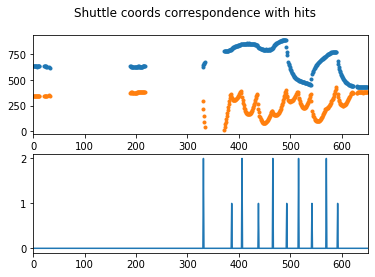

In [4]:
gt_shuttle_file = '../datasets/pro/match1/ball_trajectory/1_01_00_ball.csv'
label_file = '../datasets/pro/match1/player_hit/1_01_00.mp4_player_hit.csv'
vis_shuttle_hit_correspondence(gt_shuttle_file, label_file)

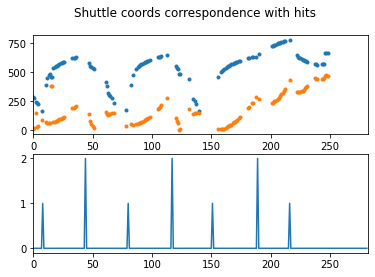

In [5]:
prefix = 'am_singles'
match = 'match_china2'
vid = 'singles0'
annot_file = os.path.join(annot_shuttle_rootdir, prefix, match, vid + '_shuttle.csv')
label_file = os.path.join(label_rootdir, prefix, match, 'player_hit', vid + '.mp4_player_hit.csv')
vis_shuttle_hit_correspondence(annot_file, label_file)

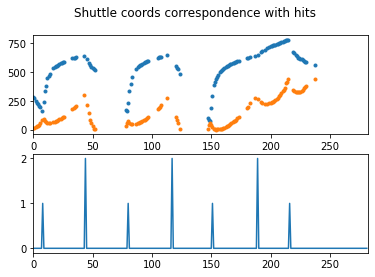

In [6]:
prefix = 'am_singles'
match = 'match_china2'
vid = 'singles0'
gt_file = os.path.join(gt_shuttle_rootdir, prefix, match, 'ball_trajectory', vid + '_ball.csv')
label_file = os.path.join(label_rootdir, prefix, match, 'player_hit', vid + '.mp4_player_hit.csv')
vis_shuttle_hit_correspondence(gt_file, label_file)

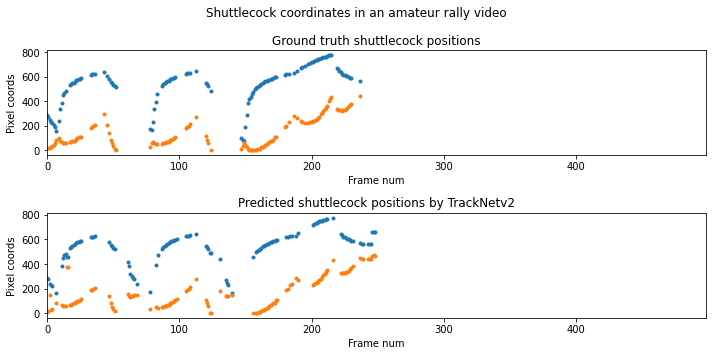

In [34]:
df_gt_shuttle = pd.read_csv(gt_file)
df_annot_shuttle = pd.read_csv(annot_file)
df_label = pd.read_csv(label_file)

shuttle_gt_coords = df_gt_shuttle[['X', 'Y']].to_numpy()
shuttle_annot_coords = df_annot_shuttle[['X', 'Y']].to_numpy()
hit_labels = df_label['player_hit'].values
frame_ind = df_label['frame'].values

if len(shuttle_gt_coords) < len(frame_ind):
    diff = len(frame_ind) - len(shuttle_gt_coords)
    zeros = np.zeros((diff, 2))
    shuttle_gt_coords = np.concatenate((shuttle_gt_coords, zeros))

shuttle_gt_frame = []
for i in range(len(frame_ind)):
    if np.any(shuttle_gt_coords[i]):
        shuttle_gt_frame.append([i, shuttle_gt_coords[i][0], shuttle_gt_coords[i][1]])
shuttle_gt_frame = np.array(shuttle_gt_frame)

if len(shuttle_annot_coords) < len(frame_ind):
    diff = len(frame_ind) - len(shuttle_annot_coords)
    zeros = np.zeros((diff, 2))
    shuttle_annot_coords = np.concatenate((shuttle_annot_coords, zeros))

shuttle_annot_frame = []
for i in range(len(frame_ind)):
    if np.any(shuttle_annot_coords[i]):
        shuttle_annot_frame.append([i, shuttle_annot_coords[i][0], shuttle_annot_coords[i][1]])
shuttle_annot_frame = np.array(shuttle_annot_frame)

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(10, 5)
fig.suptitle('Shuttlecock coordinates in an amateur rally video')
ax1.plot(shuttle_gt_frame[:,0], shuttle_gt_frame[:,1], '.')
ax1.plot(shuttle_gt_frame[:,0], shuttle_gt_frame[:, 2], '.')
ax2.plot(shuttle_annot_frame[:,0], shuttle_annot_frame[:,1], '.')
ax2.plot(shuttle_annot_frame[:,0], shuttle_annot_frame[:, 2], '.')

ax1.set_xlim([0, len(frame_ind)])
ax2.set_xlim([0, len(frame_ind)])

ax1.set_title('Ground truth shuttlecock positions')
ax2.set_title('Predicted shuttlecock positions by TrackNetv2')

ax1.set_xlabel("Frame num")
ax1.set_ylabel('Pixel coords')
ax2.set_xlabel("Frame num")
ax2.set_ylabel('Pixel coords')

plt.tight_layout()

plt.show()

## Interpolation with B-spline of degree 3, followed by computing 2nd derivative, then compare with threshold to determine hits

In [7]:
def interpolate_and_differentiate(shuttle_file):
    df_shuttle = pd.read_csv(shuttle_file)
    
    frame_ind = df_shuttle['Frame'].values
    shuttle_coords = df_shuttle[['X', 'Y']].to_numpy()

    shuttle_frame = []
    for i in range(len(frame_ind)):
        if np.any(shuttle_coords[i]):
            shuttle_frame.append([i, shuttle_coords[i][0], shuttle_coords[i][1]])
    shuttle_frame = np.array(shuttle_frame)

    # interpolation to get 2nd derivative
    spl_y = scipy.interpolate.splrep(shuttle_frame[:,0], shuttle_frame[:,2], xb=frame_ind[0], xe=frame_ind[-1], k=3) # no smoothing, 3rd order spline
    y = scipy.interpolate.splev(frame_ind, spl_y, der=0)
    ddy = scipy.interpolate.splev(frame_ind, spl_y, der=2) # use those knots to get second derivative 
    spl_x = scipy.interpolate.splrep(shuttle_frame[:,0], shuttle_frame[:,1], xb=frame_ind[0], xe=frame_ind[-1], k=3) # no smoothing, 3rd order spline
    x = scipy.interpolate.splev(frame_ind, spl_x, der=0)
    ddx = scipy.interpolate.splev(frame_ind, spl_x, der=2) # use those knots to get second derivative
    
    return x, y, ddx, ddy

                
def detect_hit_frames(shuttle_file, thresh=20, fps=30):
    x, y, ddx, ddy = interpolate_and_differentiate(shuttle_file)
    detected_frames = np.unique(np.concatenate((np.where(ddx>thresh)[0], np.where(ddy>thresh)[0]), axis=0))
    
    # ensure no two hits are within 0.5s of each other
    min_frames_apart = int(fps/2)
    filtered_frames = []
    if len(detected_frames) > 0:
        filtered_frames.append(detected_frames[0])
        for i, fr in enumerate(detected_frames):
            if i < len(detected_frames)-1:
                if detected_frames[i+1] > fr + min_frames_apart:
                    filtered_frames.append(detected_frames[i+1])
                
    return filtered_frames

def get_true_hit(label_file):
    df_label = pd.read_csv(label_file)
    hit_labels = df_label['player_hit'].values
                
    return np.where(hit_labels>0)[0]

#### Sample runs of rule-based hit detection algo

In [8]:
shuttle_file = '../datasets/pro/match1/ball_trajectory/1_01_00_ball.csv'
label_file = '../datasets/pro/match1/player_hit/1_01_00.mp4_player_hit.csv'

hit_pred = detect_hit_frames(shuttle_file, thresh=30)
hit_gt = get_true_hit(label_file)
print(hit_pred)
print(hit_gt)

[406, 437, 490, 516, 539]
[331 386 406 438 466 493 516 542 570 592]


In [9]:
prefix = 'am_singles'
match = 'match_china2'
vid = 'singles0'
shuttle_file = os.path.join(gt_shuttle_rootdir, prefix, match, 'ball_trajectory', vid + '_ball.csv')
label_file = os.path.join(label_rootdir, prefix, match, 'player_hit', vid + '.mp4_player_hit.csv')

hit_pred = detect_hit_frames(shuttle_file, thresh=30)
hit_gt = get_true_hit(label_file)
print(hit_pred)
print(hit_gt)

[7, 48, 79, 149, 212]
[  8  44  80 117 151 189 216]


In [10]:
prefix = 'am_singles'
match = 'match_china2'
vid = 'singles0'
shuttle_file = os.path.join(annot_shuttle_rootdir, prefix, match, vid + '_shuttle.csv')
label_file = os.path.join(label_rootdir, prefix, match, 'player_hit', vid + '.mp4_player_hit.csv')

hit_pred = detect_hit_frames(shuttle_file, thresh=30)
hit_gt = get_true_hit(label_file)
print(hit_pred)
print(hit_gt)

[0, 48, 123, 245]
[  8  44  80 117 151 189 216]


#### sample visualizations of interpolation and derivatives, plus validation that the second derivative works

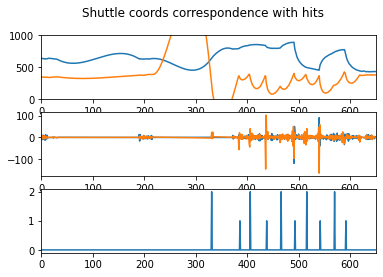

In [11]:
shuttle_file = '../datasets/pro/match1/ball_trajectory/1_01_00_ball.csv'
label_file = '../datasets/pro/match1/player_hit/1_01_00.mp4_player_hit.csv'

df_shuttle = pd.read_csv(shuttle_file)
df_label = pd.read_csv(label_file)

hit_labels = df_label['player_hit'].values
frame_ind = df_label['frame'].values
shuttle_coords = df_shuttle[['X', 'Y']].to_numpy()

shuttle_frame = []
for i in range(len(frame_ind)):
    if np.any(shuttle_coords[i]):
        shuttle_frame.append([i, shuttle_coords[i][0], shuttle_coords[i][1]])
shuttle_frame = np.array(shuttle_frame)

# interpolation to get 2nd derivative
spl_y = scipy.interpolate.splrep(shuttle_frame[:,0], shuttle_frame[:,2], xb=frame_ind[0], xe=frame_ind[-1], k=3) # no smoothing, 3rd order spline
y = scipy.interpolate.splev(frame_ind, spl_y, der=0)
ddy = scipy.interpolate.splev(frame_ind, spl_y, der=2) # use those knots to get second derivative 
spl_x = scipy.interpolate.splrep(shuttle_frame[:,0], shuttle_frame[:,1], xb=frame_ind[0], xe=frame_ind[-1], k=3) # no smoothing, 3rd order spline
x = scipy.interpolate.splev(frame_ind, spl_x, der=0)
ddx = scipy.interpolate.splev(frame_ind, spl_x, der=2) # use those knots to get second derivative

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.suptitle('Shuttle coords correspondence with hits')
ax1.plot(frame_ind, x)
ax1.plot(frame_ind, y)
ax2.plot(frame_ind, ddx)
ax2.plot(frame_ind, ddy)
ax3.plot(frame_ind, hit_labels)

ax1.set_xlim([0, len(frame_ind)])
ax1.set_ylim(0, 1000)
ax2.set_xlim([0, len(frame_ind)])
ax3.set_xlim([0, len(frame_ind)])

plt.show()

In [12]:
print(np.where(ddx > 20))
print(np.where(ddy > 20))
print(np.where(hit_labels > 0))

(array([490, 492, 540]),)
(array([331, 333, 385, 406, 437, 440, 488, 490, 492, 512, 516, 539, 541,
       542, 586]),)
(array([331, 386, 406, 438, 466, 493, 516, 542, 570, 592]),)


## Tests and evaluation to choose good threshold

In [13]:
def Intersection(lst1, lst2):
    return list(set(lst1).intersection(lst2))

def Union(lst1, lst2):
    final_list = list(set().union(lst1, lst2))
    return final_list


def clean_pred_set(true_hit_set, pred_hit_set, frame_range=3):
    # clean pred_hit_set, such that if predicted hit frame is within +-3 of true hit frame, we adjust the predicted hit frame
    min_j = 0
    for i in range(len(pred_hit_set)):
        for j in range(min_j, len(true_hit_set)):
            if pred_hit_set[i] <= true_hit_set[j]+frame_range and pred_hit_set[i] >= true_hit_set[j]-frame_range:
                pred_hit_set[i] = true_hit_set[j]
                min_j = j
                break
    pred_hit_set = np.unique(pred_hit_set)
    
    return pred_hit_set

def eval_metrics(true_hit_set, pred_hit_set, frame_range=3):
    '''
    only look at frames where hits occurred
    returns accuracy, recall, precision, f1
    '''
    pred_hit_set = clean_pred_set(true_hit_set, pred_hit_set, frame_range=frame_range)
    
    if len(true_hit_set) == 0 or len(pred_hit_set) == 0:
        acc, recall, prec, f1 = None, None, None, None
        return acc, recall, prec, f1
    
    acc = len(Intersection(true_hit_set, pred_hit_set)) / len(Union(true_hit_set, pred_hit_set))
    recall = len(Intersection(true_hit_set, pred_hit_set)) / len(true_hit_set)
    prec = len(Intersection(true_hit_set, pred_hit_set)) / len(pred_hit_set)
    if recall+prec == 0:
        f1 = 0
    else:
        f1 = 2*(recall*prec)/(recall+prec)
        
    return acc, recall, prec, f1

In [14]:
gt_shuttle_root = '../datasets/' # '../datasets/pro/match1/ball_trajectory/1_01_00_ball.csv'
annot_shuttle_root = '../data_annotations/object_level/shuttle/' # (not available for pro) 'object_level/shuttle/am_singles/match_china2/singles0_shuttle.csv'
label_root = '../datasets/' # '../datasets/pro/match1/player_hit/1_01_00.mp4_player_hit.csv'

### Hyperparameters

In [15]:
FRAME_RANGE = 6
SHUTTLE_THRESH = 25

### GT
#### pro

In [16]:
prefix = 'pro'
shuttle_rootdir = os.path.join(gt_shuttle_root, prefix)
label_rootdir = os.path.join(label_root, prefix)

rows_list = []
for matchdir in sorted(os.listdir(shuttle_rootdir)):
    if 'test' in matchdir:
        for shuttlecsv in sorted(os.listdir(os.path.join(shuttle_rootdir, matchdir, 'ball_trajectory'))):
            basename = shuttlecsv.split('_ball.csv')[0]
            label_file = os.path.join(label_rootdir, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
            shuttle_file = os.path.join(shuttle_rootdir, matchdir, 'ball_trajectory', shuttlecsv)

            # get predicted and true hit frames
            hit_pred = detect_hit_frames(shuttle_file, thresh= SHUTTLE_THRESH)
            hit_gt = get_true_hit(label_file) 

            acc, rec, prec, f1 = eval_metrics(hit_gt, hit_pred, frame_range=FRAME_RANGE) # predicted frames within +-3 of true hit frame considered True

            row_dict = {}
            row_dict['match'] = matchdir
            row_dict['vid'] = basename
            row_dict['acc'] = acc
            row_dict['rec'] = rec
            row_dict['prec'] = prec
            row_dict['f1'] = f1
            rows_list.append(row_dict.copy())
        
df_gt_pro = pd.DataFrame(rows_list)
df_gt_pro.describe()

,acc,rec,prec,f1
count,27.000000,27.000000,27.000000,27.000000
mean,0.339563,0.380708,0.718987,0.489478
std,0.143356,0.138338,0.271733,0.171775
min,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.333333,0.535714,0.400000
50%,0.350000,0.400000,0.800000,0.518519
75%,0.420168,0.457880,0.918831,0.591667
max,0.608696,0.636364,1.000000,0.756757


#### am-singles

In [17]:
prefix = 'am_singles'
shuttle_rootdir = os.path.join(gt_shuttle_root, prefix)
label_rootdir = os.path.join(label_root, prefix)

rows_list = []
for matchdir in sorted(os.listdir(shuttle_rootdir)):
    for shuttlecsv in sorted(os.listdir(os.path.join(shuttle_rootdir, matchdir, 'ball_trajectory'))):
        if shuttlecsv.endswith('.csv'):
            basename = shuttlecsv.split('_ball.csv')[0]
            label_file = os.path.join(label_rootdir, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
            shuttle_file = os.path.join(shuttle_rootdir, matchdir, 'ball_trajectory', shuttlecsv)

            # get predicted and true hit frames
            hit_pred = detect_hit_frames(shuttle_file, thresh= SHUTTLE_THRESH)
            hit_gt = get_true_hit(label_file) 

            acc, rec, prec, f1 = eval_metrics(hit_gt, hit_pred, frame_range=FRAME_RANGE) # predicted frames within +-3 of true hit frame considered True

            row_dict = {}
            row_dict['match'] = matchdir
            row_dict['vid'] = basename
            row_dict['acc'] = acc
            row_dict['rec'] = rec
            row_dict['prec'] = prec
            row_dict['f1'] = f1
            rows_list.append(row_dict.copy())
        
df_gt_am_singles = pd.DataFrame(rows_list)
df_gt_am_singles.describe()

,acc,rec,prec,f1
count,33.000000,33.000000,33.000000,33.000000
mean,0.411558,0.446254,0.823918,0.566153
std,0.151148,0.147246,0.242361,0.166087
min,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.375000,0.666667,0.500000
50%,0.428571,0.473684,1.000000,0.600000
75%,0.500000,0.500000,1.000000,0.666667
max,0.750000,0.750000,1.000000,0.857143


#### am_doubles

In [18]:
prefix = 'am_doubles'
shuttle_rootdir = os.path.join(gt_shuttle_root, prefix)
label_rootdir = os.path.join(label_root, prefix)

rows_list = []
for matchdir in sorted(os.listdir(shuttle_rootdir)):
    for shuttlecsv in sorted(os.listdir(os.path.join(shuttle_rootdir, matchdir, 'ball_trajectory'))):
        if shuttlecsv.endswith('.csv'):
            basename = shuttlecsv.split('_ball.csv')[0]
            label_file = os.path.join(label_rootdir, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
            shuttle_file = os.path.join(shuttle_rootdir, matchdir, 'ball_trajectory', shuttlecsv)

            # get predicted and true hit frames
            hit_pred = detect_hit_frames(shuttle_file, thresh= SHUTTLE_THRESH)
            hit_gt = get_true_hit(label_file) 

            acc, rec, prec, f1 = eval_metrics(hit_gt, hit_pred, frame_range=FRAME_RANGE) # predicted frames within +-3 of true hit frame considered True

            row_dict = {}
            row_dict['match'] = matchdir
            row_dict['vid'] = basename
            row_dict['acc'] = acc
            row_dict['rec'] = rec
            row_dict['prec'] = prec
            row_dict['f1'] = f1
            rows_list.append(row_dict.copy())
        
df_gt_am_doubles = pd.DataFrame(rows_list)
df_gt_am_doubles.describe()

,acc,rec,prec,f1
count,20.000000,20.000000,20.000000,20.000000
mean,0.377207,0.422636,0.739829,0.529546
std,0.149805,0.163361,0.228540,0.178840
min,0.000000,0.000000,0.000000,0.000000
25%,0.333333,0.364583,0.666667,0.500000
50%,0.373913,0.410526,0.766304,0.543779
75%,0.465909,0.547980,0.861607,0.635417
max,0.636364,0.700000,1.000000,0.777778


### annotated
only am-singles, am-doubles

In [19]:
annot_shuttle_root = '../data_annotations/object_level/shuttle/' # (not available for pro) 'object_level/shuttle/am_singles/match_china2/singles0_shuttle.csv'
label_root = '../datasets/' # '../datasets/pro/match1/player_hit/1_01_00.mp4_player_hit.csv'

#### am_singles

In [20]:
prefix = 'am_singles'
shuttle_rootdir = os.path.join(annot_shuttle_root, prefix)
label_rootdir = os.path.join(label_root, prefix)

rows_list = []
for matchdir in sorted(os.listdir(shuttle_rootdir)):
    for shuttlecsv in sorted(os.listdir(os.path.join(shuttle_rootdir, matchdir))):
        if shuttlecsv.endswith('.csv'):
            basename = shuttlecsv.split('_shuttle.csv')[0]
            label_file = os.path.join(label_rootdir, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
            shuttle_file = os.path.join(shuttle_rootdir, matchdir, shuttlecsv)

            # get predicted and true hit frames
            hit_pred = detect_hit_frames(shuttle_file, thresh= SHUTTLE_THRESH)
            hit_gt = get_true_hit(label_file) 

            acc, rec, prec, f1 = eval_metrics(hit_gt, hit_pred, frame_range=FRAME_RANGE) # predicted frames within +-3 of true hit frame considered True

            row_dict = {}
            row_dict['match'] = matchdir
            row_dict['vid'] = basename
            row_dict['acc'] = acc
            row_dict['rec'] = rec
            row_dict['prec'] = prec
            row_dict['f1'] = f1
            rows_list.append(row_dict.copy())
        
df_annot_am_singles = pd.DataFrame(rows_list)
df_annot_am_singles.describe()

,acc,rec,prec,f1
count,33.000000,33.000000,33.000000,33.000000
mean,0.374588,0.403640,0.772475,0.520016
std,0.177294,0.167955,0.303098,0.202900
min,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.285714,0.500000,0.400000
50%,0.384615,0.428571,0.916667,0.555556
75%,0.500000,0.500000,1.000000,0.666667
max,0.750000,0.750000,1.000000,0.857143


#### am_doubles

In [21]:
prefix = 'am_doubles'
shuttle_rootdir = os.path.join(annot_shuttle_root, prefix)
label_rootdir = os.path.join(label_root, prefix)

rows_list = []
for matchdir in sorted(os.listdir(shuttle_rootdir)):
    for shuttlecsv in sorted(os.listdir(os.path.join(shuttle_rootdir, matchdir))):
        if shuttlecsv.endswith('.csv'):
            basename = shuttlecsv.split('_shuttle.csv')[0]
            label_file = os.path.join(label_rootdir, matchdir, 'player_hit', basename + '.mp4_player_hit.csv')
            shuttle_file = os.path.join(shuttle_rootdir, matchdir, shuttlecsv)

            # get predicted and true hit frames
            hit_pred = detect_hit_frames(shuttle_file, thresh= SHUTTLE_THRESH)
            hit_gt = get_true_hit(label_file) 

            acc, rec, prec, f1 = eval_metrics(hit_gt, hit_pred, frame_range=FRAME_RANGE) # predicted frames within +-3 of true hit frame considered True

            row_dict = {}
            row_dict['match'] = matchdir
            row_dict['vid'] = basename
            row_dict['acc'] = acc
            row_dict['rec'] = rec
            row_dict['prec'] = prec
            row_dict['f1'] = f1
            rows_list.append(row_dict.copy())
        
df_annot_am_doubles = pd.DataFrame(rows_list)
df_annot_am_doubles.describe()

,acc,rec,prec,f1
count,20.000000,20.000000,20.000000,20.000000
mean,0.165301,0.209090,0.410537,0.269999
std,0.105344,0.130926,0.229814,0.160266
min,0.000000,0.000000,0.000000,0.000000
25%,0.082770,0.097727,0.287500,0.152885
50%,0.184659,0.215385,0.468750,0.311741
75%,0.230769,0.308333,0.559091,0.375000
max,0.350000,0.400000,0.777778,0.518519


#### Particular videos that performed well and badly

In [22]:
print('BADLY')
print(df_gt_pro[df_gt_pro['f1'] < 0.2])
print(df_gt_am_singles[df_gt_am_singles['f1'] < 0.2])
print(df_gt_am_doubles[df_gt_am_doubles['f1'] < 0.3])

BADLY
          match      vid       acc       rec  prec        f1
21  test_match3  1_05_03  0.000000  0.000000   0.0  0.000000
22  test_match3  1_06_05  0.090909  0.142857   0.2  0.166667
     match      vid  acc  rec  prec   f1
8  match24  1_04_05  0.0  0.0   0.0  0.0
             match       vid       acc       rec  prec    f1
4   match_clementi  doubles0  0.142857  0.181818   0.4  0.25
17      match_msia  doubles6  0.000000  0.000000   0.0  0.00


In [23]:
print('BADLY')
print(df_annot_am_singles[df_gt_am_singles['f1'] < 0.2])
print(df_annot_am_doubles[df_gt_am_doubles['f1'] < 0.3])

BADLY
     match      vid  acc  rec  prec   f1
8  match24  1_04_05  0.0  0.0   0.0  0.0
             match       vid       acc       rec      prec     f1
4   match_clementi  doubles0  0.230769  0.272727  0.600000  0.375
17      match_msia  doubles6  0.333333  0.400000  0.666667  0.500


In [24]:
print('GOOD')
print(df_gt_pro[df_gt_pro['f1'] > 0.75])
print(df_gt_am_singles[df_gt_am_singles['f1'] > 0.75])
print(df_gt_am_doubles[df_gt_am_doubles['f1'] > 0.75])

GOOD
         match      vid       acc       rec  prec        f1
3  test_match1  1_07_03  0.608696  0.608696   1.0  0.756757
     match      vid       acc       rec      prec        f1
3  match24  1_01_03  0.750000  0.750000  1.000000  0.857143
7  match24  1_03_05  0.611111  0.647059  0.916667  0.758621
9  match24  1_05_05  0.666667  0.666667  1.000000  0.800000
         match       vid       acc  rec   prec        f1
15  match_msia  doubles4  0.636364  0.7  0.875  0.777778
